## Import libraries

In [1]:
# standard library
import sys,os
sys.path.append(os.getcwd())
from pprint import pprint

# data and nlp
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# visualisation
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20,10


# LDA tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from utils import lda_utils

# warnings
import logging, warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/usr/local/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Read in text

In [2]:
with open("Austen_Pride.txt") as f:
    text = f.read()

__Split into individual sentences__

In [3]:
doc = nlp(text)
sentences = [sent.string.strip() for sent in doc.sents]

__Create chunks of 10 sentences at a time__

In [4]:
chunks = []
for i in range(0, len(sentences), 10):
    chunks.append(' '.join(sentences[i:i+10]))

## Process using ```gensim```

Here we're using ```gensim``` to produce efficiently procude a model of bigrams and trigrams in the data.

We first create bigrams based on words appearing one after another frequently. These bigrams are then fed into a trigram generator, which takes the bigram as the second part of a bigram.

- bigram model = (a,b)
- trigram model = (x, (a,b))

In [31]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(chunks, min_count=3, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[chunks], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

We can use the ```lda_utils.process_words()``` function to further process the data using ```spaCy```.

Make sure to check the util script and see what arguments this function takes!

In [6]:
data_processed = lda_utils.process_words(chunks,nlp, bigram_mod, trigram_mod, allowed_postags=["NOUN"])

We then need to create a ```gensim``` dictionary and a ```gensim``` corpus.

The dictionary converts each word into an integer value; the corpus creates a 'bag of words' model for all of the data - in this case, chunks of 10 sentences at a time.

In [32]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

We then feed all of this information into our LDA algorithm using ```gensim```.

In [8]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=10,
                                       passes=10,
                                       iterations=100,
                                       per_word_topics=True, 
                                       minimum_probability=0.0)

We can then calculate model perplexity and coherence in order to interpret how well the model performs.

In [9]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_processed, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.316109127702134

Coherence Score:  0.34821244385018285


Lastly, we can inspect the 'contents' of the model

In [33]:
pprint(lda_model.print_topics())

[(0,
  '0.017*"sister" + 0.016*"man" + 0.014*"time" + 0.013*"friend" + '
  '0.013*"marriage" + 0.013*"room" + 0.012*"hertfordshire" + 0.012*"daughter" '
  '+ 0.012*"manner" + 0.010*"world"'),
 (1,
  '0.025*"sister" + 0.021*"time" + 0.020*"letter" + 0.019*"family" + '
  '0.016*"friend" + 0.013*"day" + 0.013*"brother" + 0.009*"longbourn" + '
  '0.009*"room" + 0.009*"darcy"'),
 (2,
  '0.078*"door" + 0.029*"world" + 0.027*"mother" + 0.020*"parent" + '
  '0.012*"dearest" + 0.012*"kind" + 0.012*"lake" + 0.010*"idea" + '
  '0.009*"consideration" + 0.009*"yesterday"'),
 (3,
  '0.020*"room" + 0.018*"mother" + 0.015*"daughter" + 0.013*"time" + '
  '0.013*"day" + 0.012*"family" + 0.011*"spirit" + 0.011*"husband" + '
  '0.011*"place" + 0.010*"evening"'),
 (4,
  '0.022*"letter" + 0.013*"man" + 0.012*"manner" + 0.011*"father" + '
  '0.011*"way" + 0.011*"ease" + 0.010*"time" + 0.010*"distress" + '
  '0.010*"honour" + 0.009*"anger"'),
 (5,
  '0.016*"respect" + 0.015*"darcy" + 0.014*"summer" + 0.014*"y

## Run model multiple times to find best fit

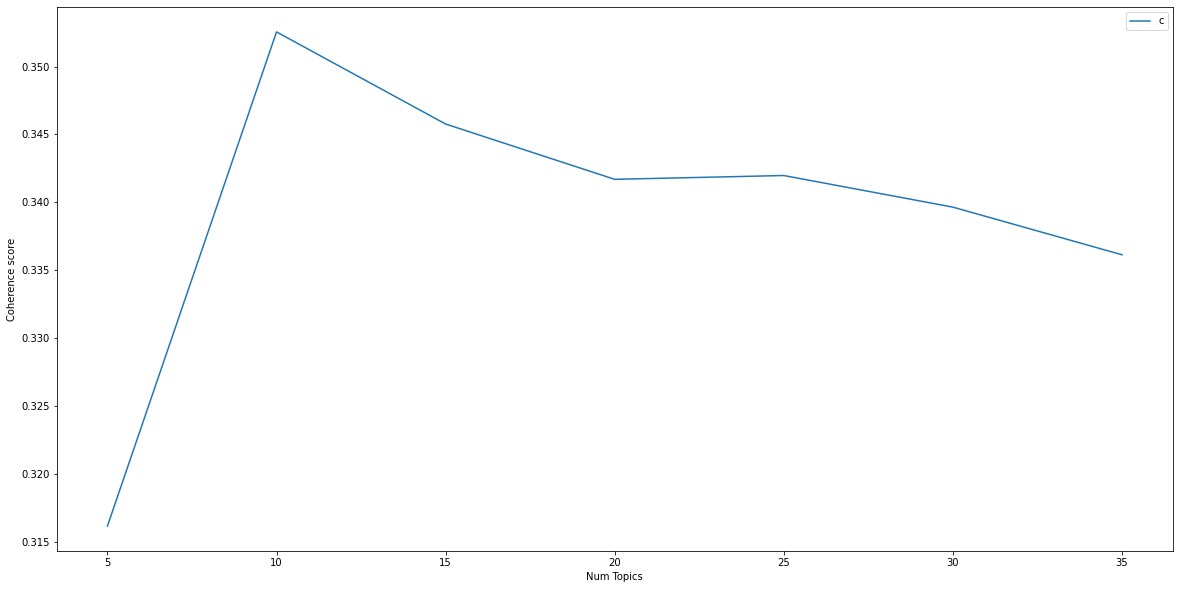

Num Topics = 5  has Coherence Value of 0.3162
Num Topics = 10  has Coherence Value of 0.3525
Num Topics = 15  has Coherence Value of 0.3458
Num Topics = 20  has Coherence Value of 0.3417
Num Topics = 25  has Coherence Value of 0.342
Num Topics = 30  has Coherence Value of 0.3396
Num Topics = 35  has Coherence Value of 0.3361


In [34]:
# Can take a long time to run.
model_list, coherence_values = lda_utils.compute_coherence_values(texts=data_processed,
                                                                  corpus=corpus, 
                                                                  dictionary=id2word,  
                                                                  start=5, 
                                                                  limit=40,  
                                                                  step=5)

## Create dataframe showing most dominant topic per chunk

In [35]:
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=data_processed)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.sample(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
182,182,0.0,0.5003,"sister, man, time, friend, marriage, room, hertfordshire, daughter, manner, world","[hertfordshire, season, feeling, loss, evident, passage, reserve]"
113,113,4.0,0.7441,"letter, man, manner, father, way, ease, time, distress, honour, anger","[daughter, interruption, cousin, affront, table, chapter, man, deficiency, nature, education, so..."
47,47,8.0,0.9437,"uncle, reason, pain, tone, recollection, hope, exertion, idea, regret, coach","[horseback, rain, night, scheme, gentleman, horse, coach, horse, farm, farm, day, purpose, extor..."
566,566,1.0,0.3720,"sister, time, letter, family, friend, day, brother, longbourn, room, darcy","[surprise, family, hearing, visitor, kind, supposition, curiosity, subject, morning, father, loo..."
315,315,9.0,0.4489,"sister, love, man, rosing, day, feeling, affection, care, thing, comfort","[man, colonel, spirit, darcy, year, attachment, rosing, compliment, allusion, mother, spirit, ca..."
301,301,9.0,0.3154,"sister, love, man, rosing, day, feeling, affection, care, thing, comfort","[remonstrance, determination, suppose, marriage, assurance, return, affection, regard, modesty, ..."
296,296,4.0,0.2795,"letter, man, manner, father, way, ease, time, distress, honour, anger","[morning, thought, meditation, length, eye, surprise, employment, breakfast, indulge, air, exerc..."
595,595,3.0,0.5439,"room, mother, daughter, time, day, family, spirit, husband, place, evening","[home, darcy, curiosity, stair, man, hope, sake, occasion, inconvenience, walk, bennet, consent,..."
610,610,1.0,0.4944,"sister, time, letter, family, friend, day, brother, longbourn, room, darcy","[befall, time, courage, sheet, paper, letter, write, admire, evenness, lady, aunt, confess, inti..."
77,77,9.0,0.9500,"sister, love, man, rosing, day, feeling, affection, care, thing, comfort","[desire, mend, mend, pen, tell, sister, improvement, harp, pray, rapture, design, table, leave, ..."


In [39]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                      axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9833,"sister, man, time, friend, marriage, room, hertfordshire, daughter, manner, world","[account, opinion, call, mine, case, representation, friend, desire, return, delay, plan, argume..."
1,1.0,0.9857,"sister, time, letter, family, friend, day, brother, longbourn, room, darcy","[property, estate, year, daughter, heir, mother, fortune, situation, life, supply, deficiency, a..."
2,2.0,0.8275,"door, world, mother, parent, dearest, kind, lake, idea, consideration, yesterday","[mother, door, prognostic, day, sister, mother, rain, evening, intermission, idea, mine, bennet,..."
3,3.0,0.9812,"room, mother, daughter, time, day, family, spirit, husband, place, evening","[duty, blessing, peace, family, reach, influence, ground, circumstance, side, lead, reject, oliv..."
4,4.0,0.9700,"letter, man, manner, father, way, ease, time, distress, honour, anger","[attention, consideration, comfort, bennet, praise, solemnity, manner, aspect, life, person, cat..."
5,5.0,0.9763,"respect, darcy, summer, year, woman, consent, character, situation, month, appearance","[card, table, opportunity, turn, whist, game, present, situation, life, compliance, reason, whis..."
6,6.0,0.9710,"character, belief, happiness, company, feeling, heart, step, evil, sense, child","[honour, believe, moment, character, lady, celerity, conduct, chance, man, horse, friend, week, ..."
7,7.0,0.9625,"face, sentiment, eye, confusion, wonder, spite, light, colonel, other, overcome","[friend, feature, face, expression, eye, other, eye, failure, symmetry, form, acknowledge, figur..."
8,8.0,0.9757,"uncle, reason, pain, tone, recollection, hope, exertion, idea, regret, coach","[word, blot, idea, time, letter, idea, correspondent, humility, appearance, humility, opinion, b..."
9,9.0,0.9820,"sister, love, man, rosing, day, feeling, affection, care, thing, comfort","[attention, affection, sister, praise, self, daughter, particular, ladyship, gratitude, mislead,..."


## Visualise topics

In [48]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.147951 -0.104302       1        1  21.232403
1      0.163213  0.004995       2        1  21.109030
9      0.140575 -0.019961       3        1  16.246376
0      0.132989 -0.010337       4        1  15.687284
4     -0.014439  0.232509       5        1   7.905807
5     -0.067334  0.074603       6        1   5.429296
8     -0.106530  0.010006       7        1   4.885444
6     -0.070228 -0.025552       8        1   3.633862
7     -0.159842 -0.075807       9        1   2.192456
2     -0.166355 -0.086154      10        1   1.678035, topic_info=           Term        Freq       Total Category  logprob  loglift
80       mother  116.000000  116.000000  Default  30.0000  30.0000
182       world   55.000000   55.000000  Default  29.0000  29.0000
655      letter  114.000000  114.000000  Default  28.0000  28.0000
193         eye   53.000000   53.000000  Default  27.0000  27.0000
64    character   50.000000   50.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
467        kind    3.125181   23.824402  Topic10  -4.4438   2.0563
1298    wedding    1.974771   12.770185  Topic10  -4.9028   2.2209
106        idea    2.733129   50.123516  Topic10  -4.5778   1.1785
109     morning    1.744993   72.223923  Topic10  -5.0265   0.3645
353    felicity    1.247208   15.708721  Topic10  -5.3623   1.5542

[595 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1056      3  0.912315    ability
823       1  0.852089    absence
823       3  0.134540    absence
1436      8  0.446410  absurdity
2199      9  0.604185    abusing
...     ...       ...        ...
27        9  0.016926       year
471       1  0.183010  yesterday
471       2  0.549031  yesterday
471      10  0.183010  yesterday
1046      3  0.897519      youth

[1026 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 10, 1, 5, 6, 9, 7, 8, 3])

## To dataframe 

In [41]:
values = list(lda_model.get_document_topics(corpus))

__Split tuples and keep only values per topic__

In [42]:
split = []
for entry in values:
    topic_prevelance = []
    for topic in entry:
        topic_prevelance.append(topic[1])
    split.append(topic_prevelance)

__Create document-topic matrix__

In [43]:
df = pd.DataFrame(map(list,zip(*split)))

In [44]:
df

,0,1,2,3,4,5,6,7,8,9,...,609,610,611,612,613,614,615,616,617,618
0,0.959080,0.006671,0.008337,0.004764,0.005557,0.003847,0.935700,0.006252,0.005885,0.006253,...,0.178067,0.003335,0.007694,0.007694,0.381143,0.111930,0.576597,0.002942,0.543850,0.486858
1,0.004547,0.006668,0.008335,0.004763,0.005557,0.003848,0.007145,0.006253,0.005884,0.006252,...,0.319106,0.494363,0.007694,0.344009,0.309810,0.088024,0.002042,0.231093,0.002223,0.263518
2,0.004546,0.006667,0.008334,0.004762,0.005556,0.003846,0.007144,0.006252,0.005884,0.006251,...,0.003847,0.184736,0.266613,0.007693,0.002778,0.001887,0.002041,0.002942,0.002223,0.002778
3,0.004547,0.006669,0.494475,0.004764,0.005558,0.003847,0.007146,0.006253,0.947042,0.006252,...,0.003847,0.003334,0.007694,0.435757,0.144005,0.202195,0.002041,0.103927,0.101048,0.002779
4,0.004547,0.006668,0.008334,0.004763,0.005556,0.003847,0.007144,0.006252,0.005884,0.006253,...,0.003847,0.179255,0.100130,0.007694,0.148372,0.035970,0.143113,0.286237,0.002223,0.156224
5,0.004547,0.006668,0.008337,0.957132,0.005557,0.965377,0.007144,0.006252,0.005884,0.006253,...,0.003847,0.003334,0.007693,0.007693,0.002779,0.099812,0.002041,0.002942,0.131429,0.002779
6,0.004546,0.006667,0.008335,0.004763,0.949989,0.003847,0.007144,0.006253,0.005884,0.006251,...,0.053640,0.003334,0.007693,0.007693,0.002778,0.001888,0.002041,0.002942,0.002223,0.002779
7,0.004546,0.006671,0.438842,0.004763,0.005556,0.003847,0.007144,0.006252,0.005884,0.006251,...,0.003847,0.003334,0.007693,0.007693,0.002778,0.001887,0.024428,0.002942,0.025951,0.002778
8,0.004546,0.006667,0.008334,0.004763,0.005556,0.003847,0.007144,0.006252,0.005884,0.006251,...,0.003848,0.076637,0.007693,0.007693,0.002778,0.025440,0.002041,0.039316,0.002223,0.033746
9,0.004547,0.939982,0.008337,0.004764,0.005557,0.003847,0.007145,0.943729,0.005885,0.943733,...,0.426104,0.048337,0.579403,0.166379,0.002778,0.430967,0.243614,0.324717,0.186607,0.045761


## Plot with seaborn

<AxesSubplot:>

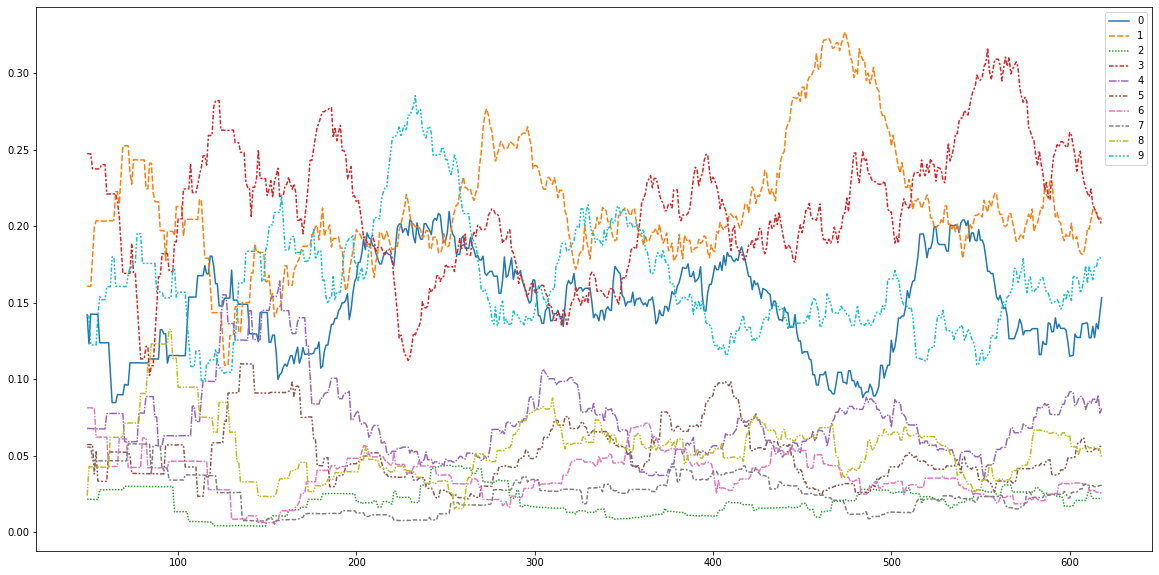

In [47]:
sns.lineplot(data=df.T.rolling(50).mean())